In [ ]:
! pip install torch

In [1]:
import numpy as np
import pickle
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import Callable, Union
from mytorch import dataiters
from mytorch.loops import generic_loop
from matplotlib import pyplot as plt
from mytorch.utils.goodies import default_eval, Timer

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
# ! pip install -U my-torch

In [3]:
dumpdir = Path('../resources/datasets/imdb/bow_onehot')
assert dumpdir.exists()

with (dumpdir/'X_train.np').open('rb') as f:
    X = np.load(f)
    
with (dumpdir/'Y_train.np').open('rb') as f:
    Y = np.load(f)

# Y = Y.reshape(-1, 1).astype(np.float32)
# X = X.astype(np.float32)
X.shape, Y.shape, X.dtype, Y.dtype

((25000, 10002), (25000, 1), dtype('float32'), dtype('float32'))

In [4]:
n_words = X.shape[1]
n_docs = X.shape[0]

In [5]:
# Shuffle the dataset (using np random permutation)
p = np.random.permutation(len(X))
X = X[p]
Y = Y[p]

In [6]:
# Split the dataset 
X_train, X_valid = X[:(int(0.8*n_docs))], X[(int(0.8*n_docs)):]
Y_train, Y_valid = Y[:(int(0.8*n_docs))], Y[(int(0.8*n_docs)):]

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((20000, 10002), (5000, 10002), (20000, 1), (5000, 1))

In [7]:
torch.tensor(Y_train).dtype

torch.float32

In [8]:
class NonLin(torch.nn.Module):

    def __init__(self, n_words):
        super().__init__()
        
        self.t1 = nn.Linear(n_words, 100, bias=False) # 10002 -> 32
#         self.drop1 = nn.Dropout(0.8)
#         self.batchnorm1 = nn.BatchNorm1d(32)
#         self.t2 = nn.Linear( 100, 50, bias=False) # 32 -> 1
#         self.drop2 = nn.Dropout(0.5)
#         self.batchnorm2 = nn.BatchNorm1d(12)
        self.t3 = nn.Linear(100, 1)
        
    def forward(self, x):

        # Layer 1
        x = self.t1(x)
#         x = self.batchnorm1(x)
#         x = torch.relu(x)
#         x = self.drop1(x)
        
        # Layer 2
#         x = self.t2(x)
# #         x = self.batchnorm2(x)
#         x = torch.relu(x)
#         x = self.drop2(x)
        
        # Layer 3
        x = self.t3(x)
        x = torch.sigmoid(x)
        return x


In [9]:
m = NonLin(n_words)
lfn = torch.nn.BCELoss()
opt = torch.optim.Adam(m.parameters(), lr=0.005)


print(m)

NonLin(
  (t1): Linear(in_features=10002, out_features=100, bias=False)
  (t3): Linear(in_features=100, out_features=1, bias=True)
)


In [10]:
epochs = 40

In [11]:
def acc(y_pred, y_true):
    return torch.mean(((y_pred > 0.5)*1.0 ==  y_true)*1.0)

In [12]:
traces = generic_loop(
    epochs = epochs,
    data = {"train": {"x": X_train, "y": Y_train}, "valid": {"x": X_valid, "y": Y_valid}},
    loss_fn = lfn,
    train_fn=m,
    predict_fn=m,
    model=m,
    device='cpu',
    opt = opt,
    eval_fn=acc
)

  0%|          | 0/311 [00:00<?, ?it/s]/home/priyansh/Dev/perm/conda/envs/main/lib/python3.8/site-packages/mytorch/loops.py:239: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  param.data = param.data.add(-weight_decay * group['lr'], param.data)
312it [00:02, 119.14it/s]                         
78it [00:00, 858.36it/s]              


Epoch: 000 | Loss: 0.33305 | Tr_c: 0.85847 | Vl_c: 0.87159 | Time: 0.044 min


312it [00:02, 127.28it/s]                         
78it [00:00, 870.00it/s]              


Epoch: 001 | Loss: 0.19851 | Tr_c: 0.92643 | Vl_c: 0.85677 | Time: 0.041 min


312it [00:02, 127.07it/s]                         
78it [00:00, 909.62it/s]              


Epoch: 002 | Loss: 0.16901 | Tr_c: 0.94867 | Vl_c: 0.84856 | Time: 0.041 min


312it [00:02, 126.67it/s]                         
78it [00:00, 698.63it/s]                        


Epoch: 003 | Loss: 0.16259 | Tr_c: 0.95533 | Vl_c: 0.79928 | Time: 0.041 min


312it [00:02, 124.38it/s]                         
78it [00:00, 926.65it/s]              


Epoch: 004 | Loss: 0.14853 | Tr_c: 0.96394 | Vl_c: 0.86238 | Time: 0.042 min


312it [00:02, 123.60it/s]                         
78it [00:00, 816.11it/s]              


Epoch: 005 | Loss: 0.17750 | Tr_c: 0.96144 | Vl_c: 0.85897 | Time: 0.042 min


312it [00:02, 122.91it/s]                         
78it [00:00, 944.50it/s]              


Epoch: 006 | Loss: 0.16298 | Tr_c: 0.96740 | Vl_c: 0.86398 | Time: 0.042 min


312it [00:02, 111.08it/s]                         
78it [00:00, 692.50it/s]                        


Epoch: 007 | Loss: 0.17789 | Tr_c: 0.96675 | Vl_c: 0.84976 | Time: 0.047 min


312it [00:02, 113.84it/s]                         
78it [00:00, 758.48it/s]                        


Epoch: 008 | Loss: 0.13599 | Tr_c: 0.97401 | Vl_c: 0.85296 | Time: 0.046 min


312it [00:02, 114.67it/s]                         
78it [00:00, 740.84it/s]                        


Epoch: 009 | Loss: 0.16134 | Tr_c: 0.97266 | Vl_c: 0.86478 | Time: 0.045 min


312it [00:02, 118.02it/s]                         
78it [00:00, 950.35it/s]              


Epoch: 010 | Loss: 0.14957 | Tr_c: 0.97296 | Vl_c: 0.85958 | Time: 0.044 min


312it [00:02, 120.12it/s]                         
78it [00:00, 875.23it/s]              


Epoch: 011 | Loss: 0.12035 | Tr_c: 0.97766 | Vl_c: 0.86599 | Time: 0.043 min


312it [00:02, 117.64it/s]                         
78it [00:00, 969.78it/s]              


Epoch: 012 | Loss: 0.12036 | Tr_c: 0.98007 | Vl_c: 0.84355 | Time: 0.044 min


312it [00:02, 115.66it/s]                         
78it [00:00, 906.49it/s]              


Epoch: 013 | Loss: 0.16787 | Tr_c: 0.97776 | Vl_c: 0.84014 | Time: 0.045 min


312it [00:02, 115.11it/s]                         
78it [00:00, 933.59it/s]              


Epoch: 014 | Loss: 0.23218 | Tr_c: 0.97681 | Vl_c: 0.84275 | Time: 0.045 min


312it [00:02, 115.49it/s]                         
78it [00:00, 915.32it/s]              


Epoch: 015 | Loss: 0.16358 | Tr_c: 0.98162 | Vl_c: 0.85397 | Time: 0.045 min


312it [00:02, 116.57it/s]                         
78it [00:00, 963.55it/s]              


Epoch: 016 | Loss: 0.12262 | Tr_c: 0.98473 | Vl_c: 0.84455 | Time: 0.045 min


312it [00:02, 115.41it/s]                         
78it [00:00, 855.76it/s]              


Epoch: 017 | Loss: 0.12442 | Tr_c: 0.98422 | Vl_c: 0.85056 | Time: 0.045 min


312it [00:02, 117.27it/s]                         
78it [00:00, 977.08it/s]              


Epoch: 018 | Loss: 0.18515 | Tr_c: 0.98062 | Vl_c: 0.85417 | Time: 0.044 min


312it [00:02, 116.61it/s]                         
78it [00:00, 904.73it/s]              


Epoch: 019 | Loss: 0.28055 | Tr_c: 0.97947 | Vl_c: 0.85457 | Time: 0.045 min


312it [00:02, 115.46it/s]                         
78it [00:00, 763.39it/s]                        


Epoch: 020 | Loss: 0.25104 | Tr_c: 0.98152 | Vl_c: 0.83914 | Time: 0.045 min


312it [00:02, 115.75it/s]                         
78it [00:00, 912.50it/s]              


Epoch: 021 | Loss: 0.19391 | Tr_c: 0.98488 | Vl_c: 0.84655 | Time: 0.045 min


312it [00:02, 115.71it/s]                         
78it [00:00, 937.92it/s]              


Epoch: 022 | Loss: 0.23671 | Tr_c: 0.98262 | Vl_c: 0.85236 | Time: 0.045 min


312it [00:02, 117.45it/s]                         
78it [00:00, 991.02it/s]              


Epoch: 023 | Loss: 0.26955 | Tr_c: 0.98252 | Vl_c: 0.85737 | Time: 0.044 min


312it [00:02, 117.51it/s]                         
78it [00:00, 999.97it/s]              


Epoch: 024 | Loss: 0.28096 | Tr_c: 0.98257 | Vl_c: 0.85877 | Time: 0.044 min


312it [00:02, 117.01it/s]                         
78it [00:00, 920.13it/s]              


Epoch: 025 | Loss: 0.33133 | Tr_c: 0.98252 | Vl_c: 0.85457 | Time: 0.044 min


312it [00:02, 118.50it/s]                         
78it [00:00, 987.94it/s]              


Epoch: 026 | Loss: 0.41056 | Tr_c: 0.97952 | Vl_c: 0.85256 | Time: 0.044 min


312it [00:02, 119.12it/s]                         
78it [00:00, 960.93it/s]              


Epoch: 027 | Loss: 0.43395 | Tr_c: 0.98032 | Vl_c: 0.84095 | Time: 0.044 min


312it [00:02, 120.03it/s]                         
78it [00:00, 981.81it/s]              


Epoch: 028 | Loss: 0.43649 | Tr_c: 0.98072 | Vl_c: 0.85056 | Time: 0.043 min


312it [00:02, 120.28it/s]                         
78it [00:00, 978.48it/s]              


Epoch: 029 | Loss: 0.34513 | Tr_c: 0.98382 | Vl_c: 0.85737 | Time: 0.043 min


312it [00:02, 121.08it/s]                         
78it [00:00, 977.95it/s]              


Epoch: 030 | Loss: 0.39246 | Tr_c: 0.98382 | Vl_c: 0.84896 | Time: 0.043 min


312it [00:02, 122.06it/s]                         
78it [00:00, 1012.09it/s]             


Epoch: 031 | Loss: 0.44675 | Tr_c: 0.98453 | Vl_c: 0.84916 | Time: 0.043 min


312it [00:02, 121.65it/s]                         
78it [00:00, 962.19it/s]              


Epoch: 032 | Loss: 0.46763 | Tr_c: 0.98317 | Vl_c: 0.84575 | Time: 0.043 min


312it [00:02, 112.18it/s]                         
78it [00:00, 772.28it/s]              


Epoch: 033 | Loss: 0.42896 | Tr_c: 0.98553 | Vl_c: 0.85557 | Time: 0.046 min


312it [00:02, 115.66it/s]                         
78it [00:00, 953.59it/s]              


Epoch: 034 | Loss: 0.38607 | Tr_c: 0.98748 | Vl_c: 0.85417 | Time: 0.045 min


312it [00:02, 109.91it/s]                         
78it [00:00, 616.02it/s]                        


Epoch: 035 | Loss: 0.39188 | Tr_c: 0.98738 | Vl_c: 0.85597 | Time: 0.047 min


312it [00:02, 110.02it/s]                         
78it [00:00, 903.10it/s]              


Epoch: 036 | Loss: 0.38638 | Tr_c: 0.98803 | Vl_c: 0.85437 | Time: 0.047 min


312it [00:02, 120.16it/s]                         
78it [00:00, 854.76it/s]              


Epoch: 037 | Loss: 0.41578 | Tr_c: 0.98653 | Vl_c: 0.85577 | Time: 0.043 min


312it [00:03, 97.98it/s]                          
78it [00:00, 927.44it/s]              


Epoch: 038 | Loss: 0.36689 | Tr_c: 0.98668 | Vl_c: 0.86078 | Time: 0.053 min


312it [00:02, 107.56it/s]                         
78it [00:00, 893.25it/s]              

Epoch: 039 | Loss: 0.31938 | Tr_c: 0.98828 | Vl_c: 0.85276 | Time: 0.048 min


In [13]:
train_acc, valid_acc, train_loss, lrs = traces

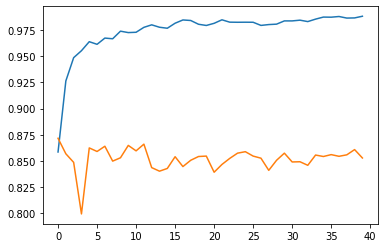

In [14]:
plt.plot(train_acc)
plt.plot(valid_acc)
# plt.plot(train_loss)

In [15]:
! free -h

              total        used        free      shared  buff/cache   available
Mem:            15G        6,0G        6,0G        740M        3,4G        8,3G
Swap:          979M        978M        1,3M


In [16]:
# Now let's see how it performs on test data 
## We hereby pledge to NEVER optimise our model on test data
with (dumpdir / 'X_test.np').open('rb') as f:
    X_test = np.load(f)
    
with (dumpdir / 'Y_test.np').open('rb') as f:
    Y_test = np.load(f)

In [17]:
# Too big to process all at once; lets use a sampler/or manually divide it into chunks before passing it to model
data_iter = dataiters.SimplestSampler({'x': X_test, 'y': Y_test})
for batch in data_iter:
    break

In [18]:
# See what batch is like if you want

In [19]:
metrics = []
for x_batch, y_batch in dataiters.SimplestSampler({'x': X_test, 'y': Y_test}):
    # convert to torch
    x = torch.tensor(x_batch)
    y_true = torch.tensor(y_batch)
    y_pred = m(x)
    
    break

In [20]:

acc(y_pred, y_true)

tensor(0.8750)